# Freq Code

In [ ]:
import numpy as np
import pywt
from scipy.signal import butter, filtfilt, find_peaks
import cv2

In [ ]:
vid_path='/Users/henryschnieders/Documents/Research/My_work/Data/100_light_62_62_padding_color.mp4'
data='/Users/henryschnieders/Documents/Research/My_work/Data/100_light_62_62_padding_color_mp4.npy'

def get_frames(video_path, desired_frames=2000):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Initialize an empty list to store frames
    frames = []

    # Frame processing loop
    frame_count = 0
    while cap.isOpened() and frame_count < desired_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize frame to the desired dimensions
        #frame_resized = cv2.resize(frame, (desired_dimensions, desired_dimensions))

        
        # Add the frame to the list
        frames.append(frame)
        
        frame_count += 1

    # Release the video capture object
    cap.release()

    return fps

fps=get_frames(vid_path)
fps


In [ ]:
def complex_mag(arr):
    return np.absolute(arr)
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, padlen=14):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, padlen=padlen)
    return y

def signal_process_alter(pix_intensity, fps):
    sampling_rate = fps

    lowcut_heart = 1.0
    highcut_heart = 3.0

    N = len(pix_intensity)  # 信号长度
    T = 1.0 / sampling_rate  # 采样间隔
    coefs = np.fft.fft(pix_intensity)  # 傅里叶变换
    freqs = np.fft.fftfreq(N, T) # 获取频率

    indices = np.where((np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart))

    coefsinrange=coefs[indices]
    freqsinrange=freqs[indices]
    max_indicies=np.argsort(complex_mag(coefsinrange))[-5:]
    coefsinrange=coefsinrange[max_indicies]
    freqsinrange=freqsinrange[max_indicies]

    wavelet='morl'
    scales=np.arange(1, 128)
    roi_mean_ = butter_bandpass_filter(pix_intensity, lowcut_heart, 3, sampling_rate, order=5)
    coef, frequencies = pywt.cwt(roi_mean_, scales, wavelet, T)
    average_spectrum = np.mean(np.abs(coef) ** 2, axis=1)
    wavelet_peaks, _ = find_peaks(average_spectrum, height=0)
    # 输出指定索引对应的频率
    # print(wavelet_peaks)
    WaveLet_heart_rate = 1.3
    if wavelet_peaks is not None:
        index_u = []
        flag_heart = True
        # flag_breath = True
        for index in reversed(wavelet_peaks):
            # print(f"索引 {index}: 频率 {frequencies[index]:.2f} Hz")
            if frequencies[index] > 1.0 and flag_heart:
                flag_heart = False
                WaveLet_heart_rate = frequencies[index]
                index_u.append(index)

    FFT_heart_rate=np.average(np.abs(freqsinrange), weights=complex_mag(coefsinrange))

    average=(FFT_heart_rate+WaveLet_heart_rate)/2*60

    return average

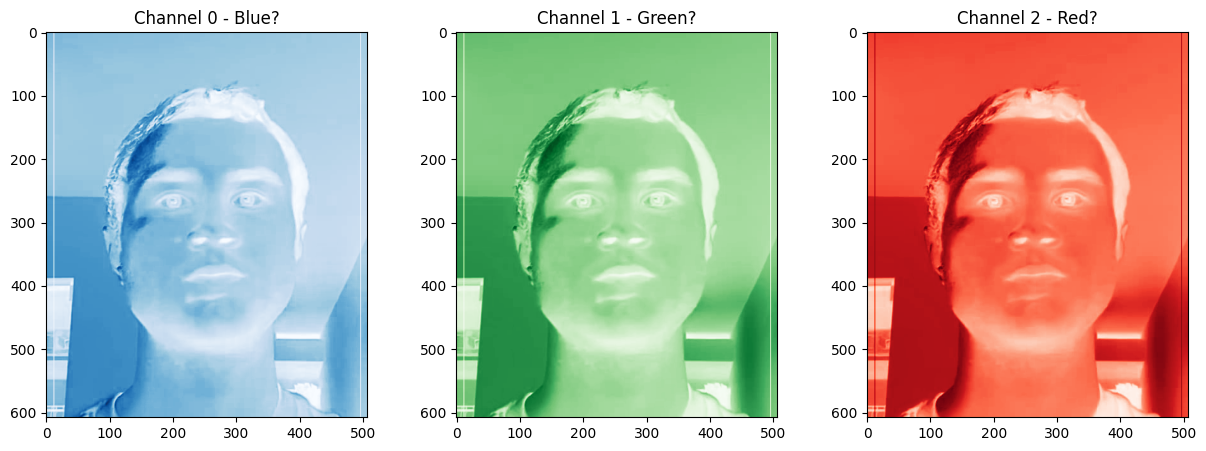

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Load the data
data = np.load('/Users/henryschnieders/Documents/Research/My_work/Data/100_light_94_94_padding_color_mp4.npy', allow_pickle=True)

# Select a sample frame
sample_frame = data[0]

# Display each channel separately in its corresponding color
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Channel 0 (assumed to be Blue)
axs[0].imshow(sample_frame[:, :, 0], cmap='Blues')
axs[0].set_title('Channel 0 - Blue?')

# Channel 1 (assumed to be Green)
axs[1].imshow(sample_frame[:, :, 1], cmap='Greens')
axs[1].set_title('Channel 1 - Green?')

# Channel 2 (assumed to be Red)
axs[2].imshow(sample_frame[:, :, 2], cmap='Reds')
axs[2].set_title('Channel 2 - Red?')

plt.show()
